{'fun': <function wrap_function.<locals>.function_wrapper at 0x13cf11da0>, 'x0': [1.5, 0], 'args': (), 'jac': <function wrap_function.<locals>.function_wrapper at 0x13d8a8400>, 'hess': <function wrap_function.<locals>.function_wrapper at 0x13d8a89a0>, 'hessp': <function wrap_function.<locals>.function_wrapper at 0x13d8a8a40>, 'subproblem': <class '__main__.DoglegSubproblem'>, 'initial_trust_radius': 3.0, 'max_trust_radius': 1000.0, 'eta': 0.0001, 'gtol': 1e-05, 'maxiter': 200, 'disp': True, 'return_all': True, 'callback': <function callback_on_crack at 0x13d8f3880>, 'unknown_options': {}, 'nfun': [0], 'njac': [0], 'nhess': [0], 'nhessp': [0], 'warnflag': 0, 'info': {'deltas': [], 'xs': [array([1.5, 0. ])], 'iters': []}, 'trust_radius': 3.0, 'x': array([1.17376195, 0.        ]), 'allvecs': [[1.5, 0]], 'm': <__main__.DoglegSubproblem object at 0x13d270680>, 'k': 0, 'p': array([-0.32623805, -0.        ]), 'hits_boundary': False, 'predicted_value': 33.99761077324065, 'x_proposed': array([1

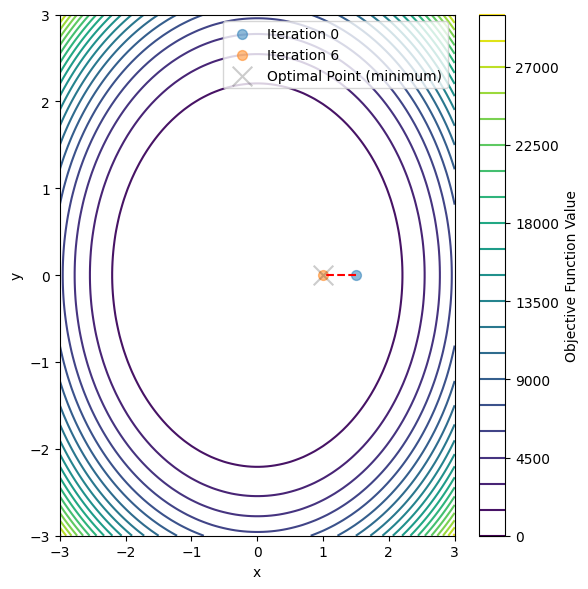

In [211]:
import numpy as np
from scipy import optimize as opt
import matplotlib.pylab as plt
import inspect
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plot
import numpy as np
import scipy.linalg
import math
import pandas as pd

import numpy as np
import csv
import scipy.linalg
import warnings
from scipy import optimize as opt
from scipy.optimize._trustregion_dogleg import DoglegSubproblem


def obj_function(xy):
    x,y, = xy
    return 100*((y**2 + x**2 - 1)**2) + (1-x)**2

def grad_f(xy):
    x,y, = xy
    return np.array([400*x*(y**2 + x**2 -1) - 2*(1 - x), 
                     400*y*(y**2 + x**2 -1)])

def hessian_f(xy):
    x,y, = xy
    return np.array([[400*(y**2 +3*x**2 - 1) + 2, 800*x*y], 
                     [800*x*y, 400*(3*y**2 + x**2 -1)]])


Nfeval = 1
__all__ = []
fun = obj_function
jac = grad_f
hess = hessian_f
# hessp = hessp_f

class OptimizeWarning(UserWarning): #setting up warning
    pass

def wrap_function(function, args):#wrapper function
    ncalls = [0]
    if function is None:
        return ncalls, None

    def function_wrapper(*wrapper_args):
        ncalls[0] += 1
        return function(*(wrapper_args + args))

    return ncalls, function_wrapper

def callback_on_crack(x):#callback to trace the values of each iteration and print
    print(inspect.currentframe().f_back.f_locals)
    print(x)

class Result(dict):
    def __getattr__(self, name):
        try:
            return self[name]
        except KeyError:
            raise AttributeError(name)

    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    def __repr__(self):
        if self.keys():
            m = max(map(len, list(self.keys()))) + 1
            return '\n'.join([k.rjust(m) + ': ' + repr(v)
                              for k, v in self.items()])
        else:
            return self.__class__.__name__ + "()"

# standard status messages of optimizers in scipy
_status_message = {'success': 'Optimization terminated successfully.',
                   'maxfev': 'Maximum number of function evaluations has '
                              'been exceeded.',
                   'maxiter': 'Maximum number of iterations has been '
                              'exceeded.',
                   'pr_loss': 'Desired error not necessarily achieved due '
                              'to precision loss.'}

class BaseQuadraticSubproblem(object):
    def __init__(self, x, fun, jac, hess=opt.rosen_hess, hessp=opt.rosen_hess_prod):
        self._x = x
        self._f = None
        self._g = None
        self._h = None
        self._g_mag = None
        self._cauchy_point = None
        self._newton_point = None
        self._fun = obj_function
        self._jac = grad_f
        self._hess = hessian_f
        self._hessp = None

    def __call__(self, p):
        return self.fun + np.dot(self.jac, p) + 0.5 * np.dot(p, self.hessp(p))

    @property
    def fun(self):
        #Value of objective function at current iteration.If the function is not set
        if self._f is None:
            self._f = self._fun(self._x)
        return self._f

    @property
    def jac(self):
        #Value of jacobian of objective function at current iteration.If there is no jacobian
        if self._g is None:
            self._g = self._jac(self._x)
        return self._g

    @property
    def hess(self):
        #Value of hessian of objective function at current iteration.If there is no Hessian
        if self._h is None:
            self._h = self._hess(self._x)
        return self._h

    def hessp(self, p):
        # Value of hessian of objective function at current iteration.If there is no Hessian
        if self._hessp is not None:
            return self._hessp(self._x, p)
        else:
            return np.dot(self.hess, p)

    @property
    def jac_mag(self):
        #Magniture of jacobian of objective function at current iteration.If it's not set
        if self._g_mag is None:
            self._g_mag = scipy.linalg.norm(self.jac)
        return self._g_mag

    def get_boundaries_intersections(self, z, d, trust_radius):#getting the boundary intersection based on trust radius
        a = np.dot(d, d)
        b = 2 * np.dot(z, d)
        c = np.dot(z, z) - trust_radius**2
        sqrt_discriminant = math.sqrt(b*b - 4*a*c)
        ta = (-b - sqrt_discriminant) / (2*a)
        tb = (-b + sqrt_discriminant) / (2*a)
        return ta, tb

    def solve(self, trust_radius):
        raise NotImplementedError('The solve method should be implemented by '
                                  'the child class')

def _minimize_trust_region(fun, x0, args=(), jac=opt.rosen_der, hess=opt.rosen_hess, hessp=opt.rosen_hess_prod,
                           subproblem=DoglegSubproblem, initial_trust_radius=3.0,
                           max_trust_radius=1000.0, eta=1e-4, gtol=1e-5,
                           maxiter=None, disp=True, return_all=True,
                           callback=callback_on_crack, **unknown_options):
    #the trust region method to solve rosenbrock function with Dogleg sub problem implementation with trust radius
    #and call back enabled
    #wrap fucntion
    nfun, fun = wrap_function(fun, args)
    njac, jac = wrap_function(jac, args)
    nhess, hess = wrap_function(hess, args)
    nhessp, hessp = wrap_function(hessp, args)

    # limiting the number of iterations
    if maxiter is None:
        maxiter = len(x0)*200

    # init the search status
    warnflag = 0

    # initializing the search
    info = {'deltas': [], 'xs':[np.array(x0)], 'iters': []}
    trust_radius = initial_trust_radius
    x = x0
    if return_all:
        allvecs = [x]
    m = subproblem(x, fun, jac, hess, hessp)#call to the dogleg sub problem
    k = 0

    # search for the function min
    while True:
        try:
            p, hits_boundary = m.solve(trust_radius)
        except np.linalg.linalg.LinAlgError as e:
            warnflag = 3
            break

        predicted_value = m(p)#predicted value at the proposed point

        #proposed point
        x_proposed = x + p
        m_proposed = subproblem(x_proposed, fun, jac, hess, hessp)

        #calculating the ratio based on actual reduction and predicted reduction
        actual_reduction = m.fun - m_proposed.fun
        predicted_reduction = m.fun - predicted_value
        if predicted_reduction <= 0:
            warnflag = 2
            break
        rho = actual_reduction / predicted_reduction

        # updating the trust radius based on rho value
        if rho < 0.25:
            trust_radius *= 0.25
        elif rho > 0.75 and hits_boundary:
            trust_radius = min(2*trust_radius, max_trust_radius)

        # if the ratio is high accept the proposed step
        if rho > eta:
            x = x_proposed
            m = m_proposed

        # if return_all:
        if callback is not None:
            callback(x)#callback to trace the values at the current iteration

        k += 1
        info['xs'].append(x)
        info['deltas'].append(trust_radius)
        info['iters'].append(k)

        # Stopping condition based on tolerance value
        if m.jac_mag < gtol:
            warnflag = 0
            break

        # Stopping conditions based on maximum number of iterations
        if k >= maxiter:
            warnflag = 1
            break

            # Default status messages
    status_messages = (
        _status_message['success'],
        _status_message['maxiter'],
        'A bad approximation caused failure to predict improvement.',
        'A linalg error occurred, such as a non-psd Hessian.',
    )

    #Scipy display options if no warning
    if disp:
        if warnflag == 0:
            print(status_messages[warnflag])
        else:
            print('Warning: ' + status_messages[warnflag])
        # print("         Current function value: %f")
        print("         Iterations: %d" % k)
        print("         Function evaluations: %d" % nfun[0])
        print("         Gradient evaluations: %d" % njac[0])
        print("         Hessian evaluations: %d" % nhess[0])

    result = Result(x=x, success=(warnflag == 0), status=warnflag, fun= opt.rosen,
                    jac=m.jac, nfev=nfun[0], njev=njac[0], nhev=nhess[0],
                    nit=k, message=status_messages[warnflag])
    return info

def _minimize_dogleg(fun, x0, args=(), jac=grad_f, hess=hessian_f,
                     **trust_region_options):
    return _minimize_trust_region(fun, x0, args=args, jac=jac, hess=hess,
                                  subproblem=DoglegSubproblem,
                                  **trust_region_options)

#Dogleg Sub problem
class DoglegSubproblem(BaseQuadraticSubproblem):
    def cauchy_point(self):
        if self._cauchy_point is None:
            g = self.jac
            Bg = self.hessp(g)
            self._cauchy_point = -(np.dot(g, g) / np.dot(g, Bg)) * g #defining the cauchy point
        return self._cauchy_point

    def newton_point(self):
        if self._newton_point is None:
            g = self.jac
            B = self.hess
            cho_info = scipy.linalg.cho_factor(B)
            self._newton_point = -scipy.linalg.cho_solve(cho_info, g)
        return self._newton_point

    def solve(self, trust_radius):
        p_best = self.newton_point()
        if scipy.linalg.norm(p_best) < trust_radius:
            hits_boundary = False
            return p_best, hits_boundary

        # Compute the Cauchy point.
        p_u = self.cauchy_point()

        # If the Cauchy point is outside the trust region
        # return the point where the path intersects the boundary.
        p_u_norm = scipy.linalg.norm(p_u)
        if p_u_norm >= trust_radius:
            p_boundary = p_u * (trust_radius / p_u_norm)
            hits_boundary = True
            return p_boundary, hits_boundary

        _, tb = self.get_boundaries_intersections(p_u, p_best - p_u,
                                                  trust_radius)
        p_boundary = p_u + tb * (p_best - p_u)
        hits_boundary = True
        return p_boundary, hits_boundary

    
x0 = [1.5, 0]
info = _minimize_dogleg(fun,x0, maxiter=200, callback=callback_on_crack)
csv_file_path = "DoglegOne_1half_1half.csv"
fieldnames = list(info.keys())

# Open the CSV file for writing
with open(csv_file_path, 'w', newline='') as csvfile:
    # Create a CSV DictWriter
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    csv_writer.writeheader()
    csv_writer.writerow(info)

cos = []
for co in info['xs']:
    cos.append([co[0], co[1]])
cos = np.array(cos)

# Create a meshgrid of points at which to evaluate fxy
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)

# Evaluate fxy at each point on the grid
Z = obj_function([X, Y])


plt.figure(figsize=(6,6))
contour = plt.contour(X, Y, Z, levels=25, cmap='viridis') 
plt.colorbar(contour, label='Objective Function Value')
for i in range(0,len(cos),15):
    plt.scatter(cos[i,0], cos[i,1], s=50, label=f'Iteration {i}', alpha=0.5)
plt.scatter(cos[-1,0], cos[-1,1], s=50, label=f'Iteration {len(cos)}', alpha=0.5)
plt.plot(cos[:,0],cos[:,1], color='red', linestyle='dashed')
plt.scatter(1,0, color='black', marker='x', label='Optimal Point (minimum)', alpha=0.2, s=200)
# plt.title(f'Plotting the Descent for {x0} against contour plot') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc=0)
plt.tight_layout()
# no convergence after 2000 iterations

In [212]:
def convergence_history(f, df, d2f, info, xMin, p, H=None):
        ''' Compute norms of errors of iterates, function values, and gradients (in p-norm)
        
        # INPUTS
            info: dictionary with optimization history returned by an optimization function
            - xs: iterates
            - alphas: step sizes (optional)
            xMin: true minimum, if empty last entry of info['xs'][:,-1] is used
            p: p >= 1: p-Euclidean norm || x ||_p, ),
            p='M': M weighted 2-norm || x ||_M i.e., (x^T M x)^{1/2} with M = H or if H = [], M = F.f2f(xMin)

        # OUTPUTS
            con: dictionary with p-norms of convergence of
            - x: iterates i.e., || x_k - xMin ||_p,  k - iteration index
            - f: difference in function values i.e., (f(x_k) - f(xMin)), k - iteration index
            - df: gradients i.e., || f(x_k) - f(xMin) ||_p, k - iteration index
            
        convert info['xs'] to numpy array '''

        arr = np.zeros(shape=(2,len(info['xs'])))
        for i in range(len(info['xs'])):
            x = info['xs'][i][0]
            y = info['xs'][i][1]
            arr[0][i] = x
            arr[1][i] = y

        if xMin is None:
            xMin = (arr[0][-1], arr[1][-1])
        
        shape = arr.shape[1]
        # con = {'x': [], 'f': [], 'df': []
        if p == 'M':
            p = 2
            if H is not None:
                M = H
            else:
                M = d2f(xMin)  # M is the Hessian at the solution, M has to be symmetric positive definite
            
            # Convergence of iterates: || x_k - xMin ||_M
            #err = xs - np.tile(xMin, (xs.shape[0], 1))
            err = info['xs'] - np.tile(xMin, (shape, 1))            
            # err = xs - np.tile(x_min[:, np.newaxis], (1, xs.shape[1]))
            con_x = [np.sqrt(np.dot(err[k].T, M.dot(err[k]))) for k in range(shape)]
            # con['x'] = [np.sqrt(err[:, k].T @ M @ err[:, k]) for k in range(err.shape[1])]
        else:
            # Convergence of iterates: || x_k - xMin ||_p
            # err = xs - np.tile(x_min[:, np.newaxis], (1, xs.shape[1]))
            # con['x'] = np.sum(np.abs(err)*p, axis=0)*(1/p)
            con_x = np.sum(np.abs(arr - np.array([xMin[0], xMin[1]]*shape).reshape(2,shape)) ** p, axis=0)**(1/p)

        if f is not None:
            # Convergence of function values: f(x_k) - f(xMin)
            # con['f'] = [f(xs[:, k]) - f(x_min) for k in range(xs.shape[1])]
            # con['df'] = [np.linalg.norm(df(xs[:, k]), ord=p) for k in range(xs.shape[1])
            con_f = [f([arr[0,k], arr[1,k]]) - f(xMin) for k in range(arr.shape[1])]

            # Convergence of gradient: || f(x_k)||_p
            con_df = [np.sum(np.abs(df([arr[0,k], arr[1,k]]))*p)*(1/p) for k in range(shape)]
        else:
            con_f = []
            con_df = []

        return {'x': con_x, 'f': con_f, 'df': con_df} # con

conInfo = convergence_history(f=obj_function, df=grad_f, d2f=hessian_f, info=info, xMin=[1,0], p=2, H=None)

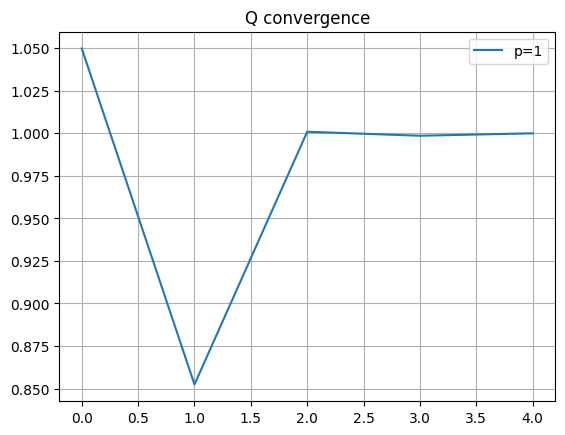

In [213]:
# Q convergence 
p = 1
rs1 = conInfo['x'][1:] / (conInfo['x'][:-1]**p)
ps = 1.4
rss = conInfo['x'][1:] / (conInfo['x'][:-1]**ps)
p = 2
rs2 = conInfo['x'][1:] / (conInfo['x'][:-1]**p)

plt.figure()
plt.plot(rs1)
plt.title('Q convergence')
plt.legend(['p=1'])
plt.grid(True)

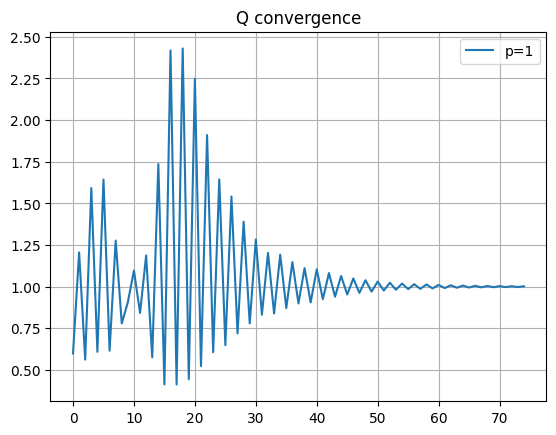

In [193]:
# Error plotting - PLOT POINTS OF INACTIVE AND ACTIVE TRUST REGION
def q_conv(info=info, xMin=[1,0], H = None, x0=x0, p=2):

    arr = np.zeros(shape=(2,len(info['xs'])))
    for i in range(len(info['xs'])):
        x = info['xs'][i][0]
        y = info['xs'][i][1]
        arr[0][i] = x
        arr[1][i] = y

    if xMin is None:
        xMin = (arr[0][-1], arr[1][-1])

    shape = arr.shape[1]
    if p == 'M':
        p = 2
        if H is not None:
            M = H
        else:
            M = hessian_f(xMin)  # M is the Hessian at the solution, M has to be symmetric positive definite
        
        # Convergence of iterates: || x_k - xMin ||_M
        err = info['xs'] - np.tile(xMin, (2, shape))            
        # err = xs - np.tile(x_min[:, np.newaxis], (1, xs.shape[1]))
        con_x = [np.sqrt(np.dot(err[k].T, M.dot(err[k]))) for k in range(shape)]
    else:
        # Convergence of iterates: || x_k - xMin ||_p
        # print((arr - np.array([xMin[0], xMin[1]]*shape).reshape(2,shape)).shape)
        con_x = np.sum(np.abs(arr - np.array([xMin[0], xMin[1]]*shape).reshape(2,shape))**p, axis=0)**(1/p)
    if obj_function is not None:
        # Convergence of function values: f(x_k) - f(xMin)
        con_f = [obj_function([arr[0,k], arr[1,k]]) - obj_function(xMin) for k in range(shape)]
        # Convergence of gradient: || f(x_k)||_p
        con_df = [np.sum(np.abs(grad_f([arr[0,k], arr[1,k]]))**p)**(1/p) for k in range(shape)]
    else:
        con_f = []
        con_df = []


    conInfo = {'x': con_x, 'f': con_f, 'df': con_df} 

    # # Q convergence
    p = 1
    rs1 = conInfo['x'][1:] / (conInfo['x'][:-1]**p)
    ps = 1.4
    rss = conInfo['x'][1:] / (conInfo['x'][:-1]**ps)
    p = 2
    rs2 = conInfo['x'][1:] / (conInfo['x'][:-1]**p)

    plt.figure()
    plt.plot(rs1)
    plt.title('Q convergence')
    plt.legend(['p=1'])
    plt.grid(True)

q_conv(info=info, xMin=[1,0], H = None, x0=x0, p=2)

{'fun': <function wrap_function.<locals>.function_wrapper at 0x13df4d620>, 'x0': [1.5, 1e-06], 'args': (), 'jac': <function wrap_function.<locals>.function_wrapper at 0x13f72a980>, 'hess': <function wrap_function.<locals>.function_wrapper at 0x13f72b380>, 'hessp': <function wrap_function.<locals>.function_wrapper at 0x13f72b100>, 'subproblem': <class '__main__.DoglegSubproblem'>, 'initial_trust_radius': 3.0, 'max_trust_radius': 1000.0, 'eta': 0.0001, 'gtol': 1e-05, 'maxiter': 200, 'disp': True, 'return_all': True, 'callback': <function callback_on_crack at 0x13d93dda0>, 'unknown_options': {}, 'nfun': [0], 'njac': [0], 'nhess': [0], 'nhessp': [0], 'warnflag': 0, 'info': {'deltas': [], 'xs': [array([1.5e+00, 1.0e-06])], 'iters': []}, 'trust_radius': 3.0, 'x': array([1.17376195e+00, 7.82971329e-07]), 'allvecs': [[1.5, 1e-06]], 'm': <__main__.DoglegSubproblem object at 0x13f0a4fe0>, 'k': 0, 'p': array([-3.26238054e-01, -2.17028671e-07]), 'hits_boundary': False, 'predicted_value': 33.997610

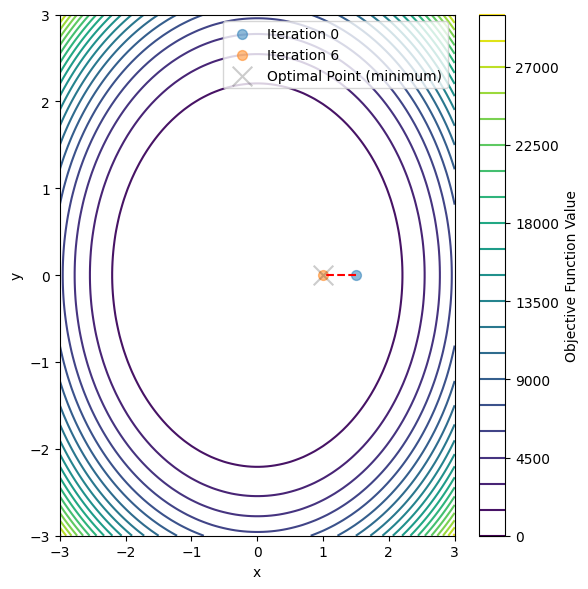

In [179]:
x0 = [1.5, 0.000001]
info = _minimize_dogleg(fun,x0, maxiter=200, callback=callback_on_crack)
csv_file_path = "DoglegOne_1half_zero.csv"
fieldnames = list(info.keys())

# Open the CSV file for writing
with open(csv_file_path, 'w', newline='') as csvfile:
    # Create a CSV DictWriter
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Write the header
    csv_writer.writeheader()

    # Write the data
    csv_writer.writerow(info)

cos = []
for co in info['xs']:
    cos.append([co[0], co[1]])
cos = np.array(cos)

# Create a meshgrid of points at which to evaluate fxy
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)

# Evaluate fxy at each point on the grid
Z = obj_function([X, Y])


plt.figure(figsize=(6,6))
contour = plt.contour(X, Y, Z, levels=25, cmap='viridis') 
plt.colorbar(contour, label='Objective Function Value')
for i in range(0,len(cos),50):
    plt.scatter(cos[i,0], cos[i,1], s=50, label=f'Iteration {i}', alpha=0.5)
plt.scatter(cos[-1,0], cos[-1,1], s=50, label=f'Iteration {len(cos)}', alpha=0.5)
plt.plot(cos[:,0],cos[:,1], color='red', linestyle='dashed')
plt.scatter(1,0, color='black', marker='x', label='Optimal Point (minimum)', alpha=0.2, s=200)
# plt.title(f'Plotting the Descent for [1.5, 0] against contour plot') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc=0)
plt.tight_layout()
# convergence after 2000 iterations

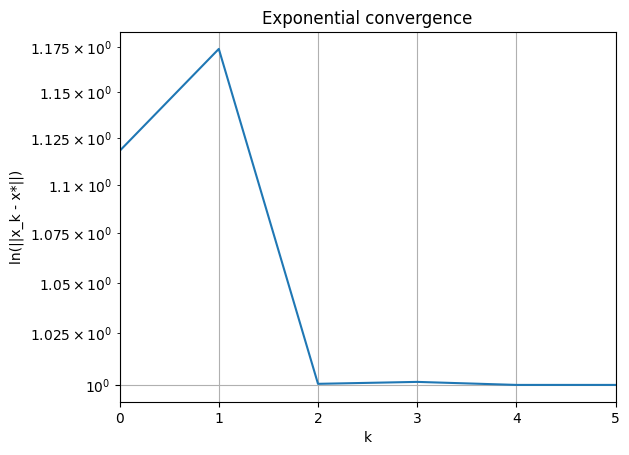

In [180]:
# error
q_conv(info=info, xMin=[1,0], H = None, x0=[1.5, 0.000001], p=2)

{'fun': <function wrap_function.<locals>.function_wrapper at 0x13d6611c0>, 'x0': [1.5, 0.1], 'args': (), 'jac': <function wrap_function.<locals>.function_wrapper at 0x13d6614e0>, 'hess': <function wrap_function.<locals>.function_wrapper at 0x13d660f40>, 'hessp': <function wrap_function.<locals>.function_wrapper at 0x13d660720>, 'subproblem': <class '__main__.DoglegSubproblem'>, 'initial_trust_radius': 3.0, 'max_trust_radius': 1000.0, 'eta': 0.0001, 'gtol': 1e-05, 'maxiter': 200, 'disp': True, 'return_all': True, 'callback': <function callback_on_crack at 0x13de0a520>, 'unknown_options': {}, 'nfun': [0], 'njac': [0], 'nhess': [0], 'nhessp': [0], 'warnflag': 0, 'info': {'deltas': [], 'xs': [array([1.5, 0.1])], 'iters': []}, 'trust_radius': 3.0, 'x': array([1.17285848, 0.07823629]), 'allvecs': [[1.5, 0.1]], 'm': <__main__.DoglegSubproblem object at 0x13f15e2a0>, 'k': 0, 'p': array([-0.32714152, -0.02176371]), 'hits_boundary': False, 'predicted_value': 34.63848762552816, 'x_proposed': arra

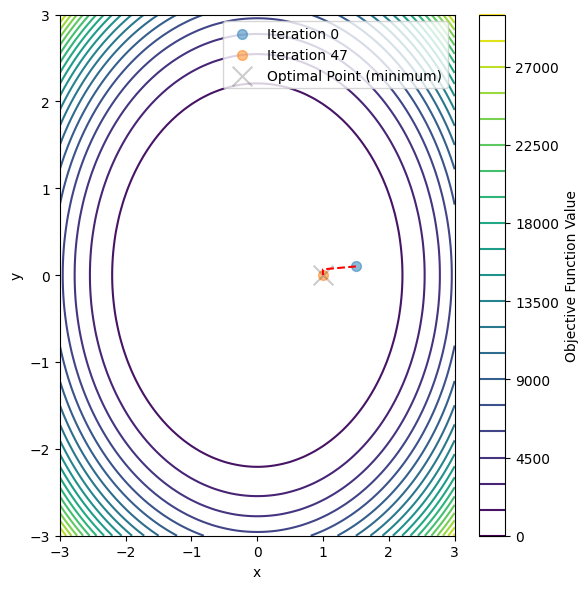

In [168]:
x0 = [1.5, 0.1]
info = _minimize_dogleg(fun,x0, maxiter=200, callback=callback_on_crack)
csv_file_path = "DoglegOne_zero_zero.csv"
fieldnames = list(info.keys())

# Open the CSV file for writing
with open(csv_file_path, 'w', newline='') as csvfile:
    # Create a CSV DictWriter
    csv_writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Write the header
    csv_writer.writeheader()

    # Write the data
    csv_writer.writerow(info)

cos = []
for co in info['xs']:
    cos.append([co[0], co[1]])
cos = np.array(cos)

# Create a meshgrid of points at which to evaluate fxy
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x, y)

# Evaluate fxy at each point on the grid
Z = obj_function([X, Y])


plt.figure(figsize=(6,6))
contour = plt.contour(X, Y, Z, levels=25, cmap='viridis') 
plt.colorbar(contour, label='Objective Function Value')
for i in range(0,len(cos),50):
    plt.scatter(cos[i,0], cos[i,1], s=50, label=f'Iteration {i}', alpha=0.5)
plt.scatter(cos[-1,0], cos[-1,1], s=50, label=f'Iteration {len(cos)}', alpha=0.5)
plt.plot(cos[:,0],cos[:,1], color='red', linestyle='dashed')
plt.scatter(1,0, color='black', marker='x', label='Optimal Point (minimum)', alpha=0.2, s=200)
# plt.title(f'Plotting the Descent for [0,0] against contour plot') 
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc=0)
plt.tight_layout()
# No Convergence after 2000 iterations